<a href="https://colab.research.google.com/github/hegone/urban-pollution-trends-ml/blob/main/ARIMA_NO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-55597d2a0378>:14: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  data_2020_onwards = data['no2']['2020-01-01':].resample('M').mean()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc

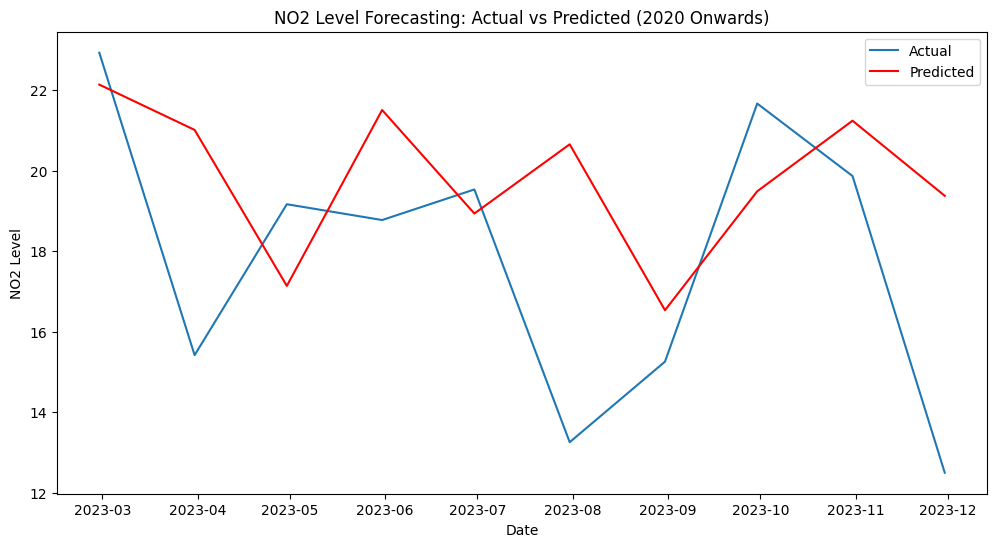

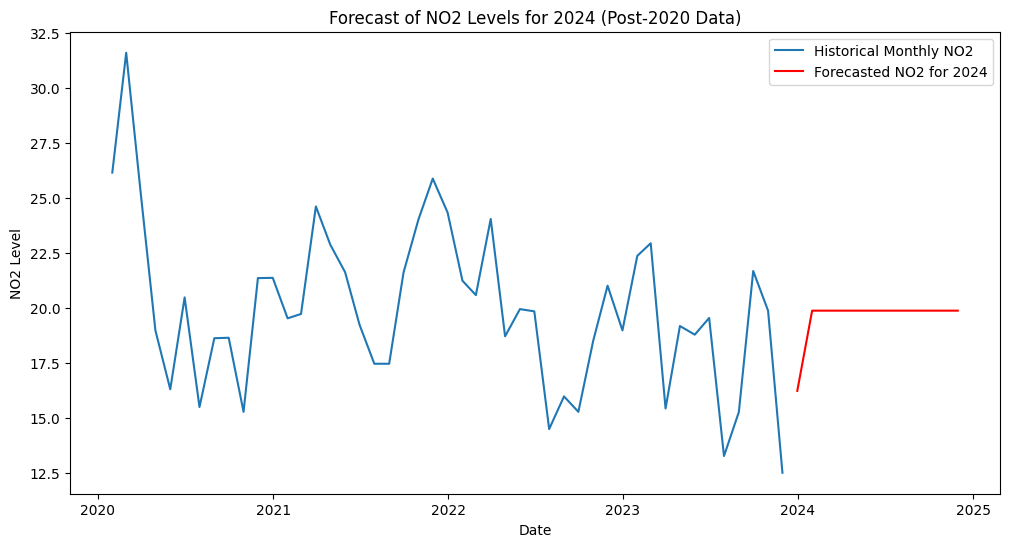

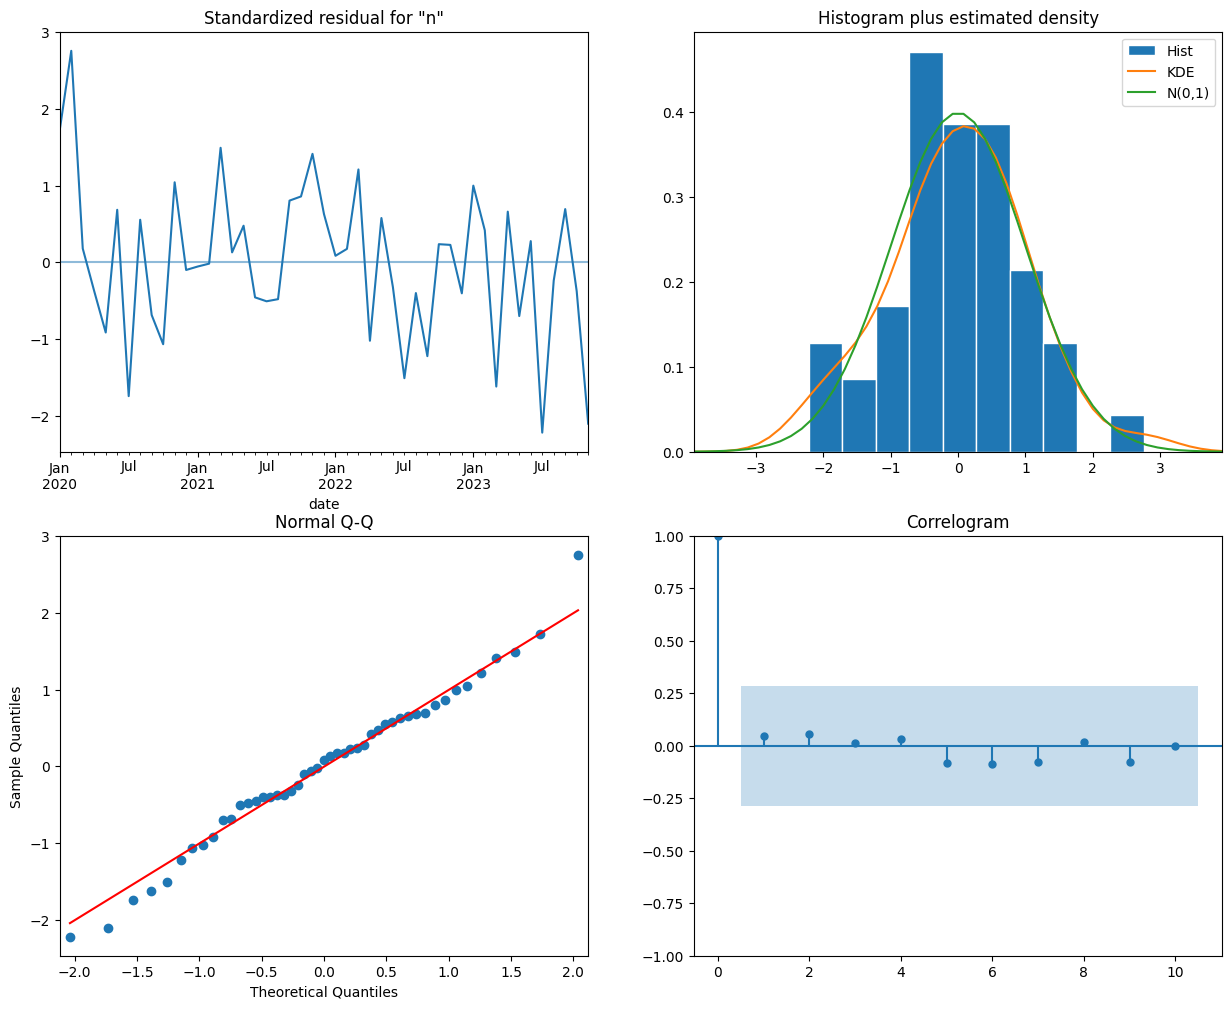

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import itertools
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Load and preprocess the data
file_path = '/content/drive/MyDrive/Air Quality Forecast/London/Cleaned_London_Air_Quality.csv' # replace with adeqaute file location
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data_2020_onwards = data['no2']['2020-01-01':].resample('M').mean()

# Function to find the order of differencing (d)
def find_d_order(ts):
    d = 0
    result = adfuller(ts)
    while result[1] > 0.05:
        ts = ts.diff().dropna()
        result = adfuller(ts)
        d += 1
    return d

# Function to train ARIMA model and perform cross-validation
def train_arima(series, order, train_size):
    history = [x for x in series[:train_size]]
    predictions = []

    # Walk-forward validation
    for t in range(len(series) - train_size):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(series[train_size + t])

    error = sqrt(mean_squared_error(series[train_size:], predictions))
    return predictions, error

# Find the optimal order of differencing
d_order = find_d_order(data_2020_onwards)

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
pdq = list(itertools.product(p, [d_order], q))

# Grid Search for ARIMA parameters
aic_values = {}
for param in pdq:
    try:
        model = ARIMA(data_2020_onwards, order=param)
        model_fit = model.fit()
        aic_values[param] = model_fit.aic
    except:
        continue

# Find the parameters with minimum AIC
min_aic_param = min(aic_values, key=aic_values.get)

# Splitting the dataset into train and test sets for cross-validation
train_size = int(len(data_2020_onwards) * 0.8)
train, test = data_2020_onwards[0:train_size], data_2020_onwards[train_size:]

# Train the ARIMA model and perform cross-validation
predictions, rmse = train_arima(data_2020_onwards, min_aic_param, train_size)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data_2020_onwards.index[train_size:], data_2020_onwards[train_size:], label='Actual')
plt.plot(data_2020_onwards.index[train_size:], predictions, color='red', label='Predicted')
plt.title('NO2 Level Forecasting: Actual vs Predicted (2020 Onwards)')
plt.xlabel('Date')
plt.ylabel('NO2 Level')
plt.legend()
plt.show()

# Forecasting NO2 levels for 2024
model = ARIMA(data_2020_onwards, order=min_aic_param)
model_fit = model.fit()
forecast = model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=data_2020_onwards.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(data_2020_onwards.index, data_2020_onwards, label='Historical Monthly NO2')
plt.plot(forecast_index, forecast, color='red', label='Forecasted NO2 for 2024')
plt.title('Forecast of NO2 Levels for 2024 (Post-2020 Data)')
plt.xlabel('Date')
plt.ylabel('NO2 Level')
plt.legend()
plt.show()

# Fit the ARIMA model
model = ARIMA(data_2020_onwards, order=min_aic_param)
model_fit = model.fit()

# Plot the diagnostics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()



The diagnostic plots provide insight into the residuals of the ARIMA model:

Standardized Residuals: They should ideally show no pattern. The plot indicates some fluctuations, but there's no clear pattern, which is good.
Histogram and KDE (Kernel Density Estimate): The KDE line should follow closely with the N(0,1) line (which represents the normal distribution) if the residuals are normally distributed. The histogram suggests a slight deviation from normality, particularly around the center of the distribution.
Normal Q-Q Plot: Most of the dots fall along the red line, indicating that the residuals are normally distributed, but there are some deviations on the tails.
Correlogram (ACF Plot): Shows the autocorrelation of the residuals at different lags. We're looking for no significant correlation here, which seems to be the case as all lags are within the confidence interval.

This code will first plot the seasonal decomposition to visually inspect seasonality. Then, it uses auto_arima from the pmdarima package to automatically find the best SARIMA parameters, considering seasonality.

In [ ]:
pip install pmdarima

<ipython-input-6-b2aed24e035c>:16: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  data_2020_onwards = data['no2']['2020-01-01':].resample('M').mean()


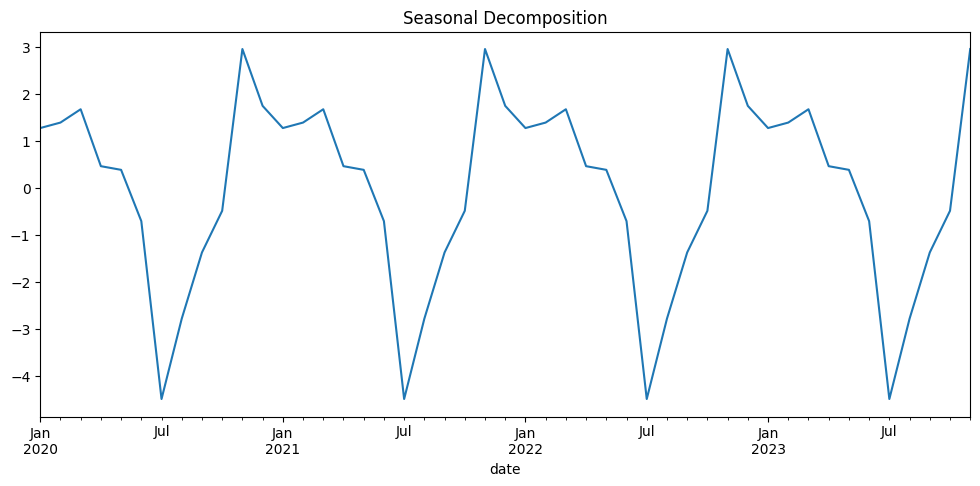

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=258.447, Time=1.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=259.959, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=251.877, Time=0.32 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=250.859, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=418.224, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=248.928, Time=0.07 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=250.863, Time=0.38 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=252.860, Time=0.59 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=250.516, Time=0.40 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=250.562, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=249.906, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=252.459, Time=0.57 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 5.039 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -121.464
Date:                Tue, 12 Dec 2023   AIC                            248.928
Time:                        21:32:06   BIC                            254.478
Sample:                    01-31-2020   HQIC                           251.017
                         - 11-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.8648      0.759     26.188      0.000      18.378      21.351
ma.L1          0.5430      0.169      3.222      0.001       0.213       0.873
sigma2        10.2100      2.083      4.903      0.000       6.128      14.292
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.74   Prob(JB):                         0.94
Heteroskedasticity (H):               0.82   Skew:                             0.01
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Load and preprocess the data
file_path = '/content/drive/MyDrive/Air Quality Forecast/London/Cleaned_London_Air_Quality.csv'
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data_2020_onwards = data['no2']['2020-01-01':].resample('M').mean()

# Check for seasonality
seasonal_decompose_result = seasonal_decompose(data_2020_onwards, model='additive')
seasonal_decompose_result.seasonal.plot(title="Seasonal Decomposition", figsize=(12, 5))
plt.show()

# Perform grid search to find the best SARIMA parameters
# The seasonal period s is typically known from domain knowledge, e.g., s = 12 for monthly data with yearly seasonality
s = 12

# Using auto_arima to find the best SARIMA parameters
sarima_model = auto_arima(data_2020_onwards, seasonal=True, m=s, trace=True,
                          error_action='ignore', suppress_warnings=True)

# Best model summary
sarima_model.summary()


The seasonal decomposition plot shows a recurring pattern that suggests seasonality in the data, which is a good indication that a SARIMA model could be suitable.

The auto_arima function has identified an ARIMA(0,0,1) model without a seasonal component as the best model based on the AIC criterion. This is a bit surprising given the seasonality observed in the data. The model is essentially a moving average (MA) model with one lag, and it includes an intercept. This might imply that the seasonal fluctuations are not strong enough to require a separate seasonal component, or that the seasonal pattern is not consistent enough to be captured by a SARIMA model.

                                     SARIMAX Results                                      
Dep. Variable:                                no2   No. Observations:                   47
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -87.626
Date:                            Tue, 12 Dec 2023   AIC                            183.251
Time:                                    21:35:04   BIC                            189.237
Sample:                                01-31-2020   HQIC                           185.265
                                     - 11-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          2.5357      1.259      2.015      0.044       0.069       5.003
ar.S.L12       0.9518      0.030   

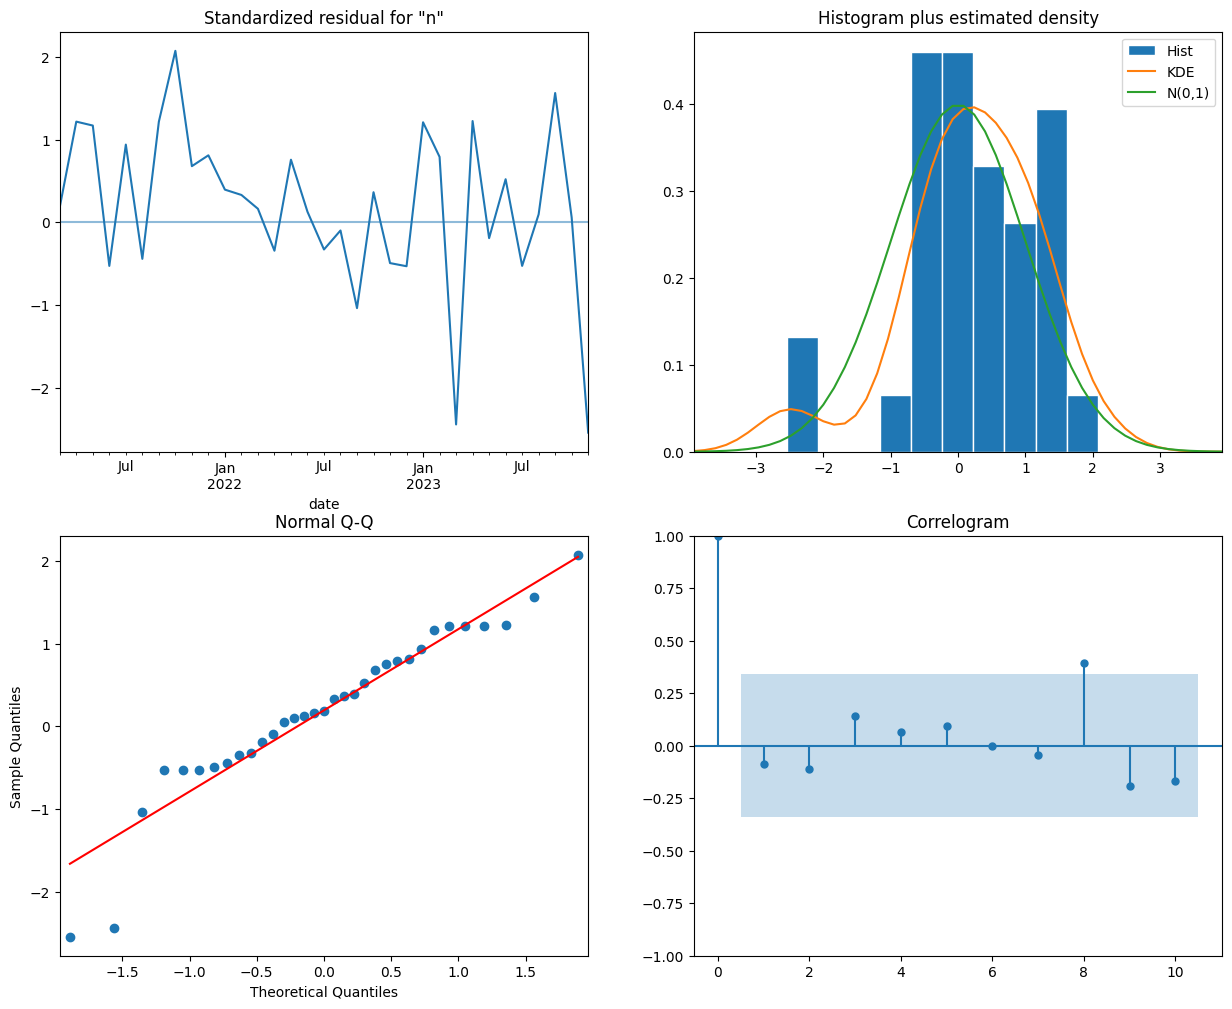

In [ ]:
# Manually configure the SARIMA model with a seasonal component
sarima_model = SARIMAX(data_2020_onwards,
                       order=(0, 0, 1),              # (p, d, q)
                       seasonal_order=(1, 0, 1, 12), # (P, D, Q, s)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Model summary
print(sarima_result.summary())

# Perform diagnostics on the fitted model
sarima_result.plot_diagnostics(figsize=(15, 12))
plt.show()


Standardized Residuals: The residuals seem to fluctuate around zero without clear patterns or trends, which is a good sign. There are a few spikes, but these do not seem systematic.
Histogram and KDE: The residuals somewhat resemble a normal distribution, as indicated by the KDE curve, but there is a noticeable deviation. This could be due to the presence of outliers or non-normal behavior in the data.
Normal Q-Q Plot: Most points lie on the line, but there are deviations on the tails. This again suggests that the residuals are mostly normally distributed, but with potential outliers or extreme values.
Correlogram: The correlogram shows that the autocorrelation for most lags is within the confidence interval, which is good. However, there's a significant spike at lag 1 that we should investigate further.


<ipython-input-10-28a1765a58f5>:14: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  data_2020_onwards = data['no2']['2020-01-01':].resample('M').mean()


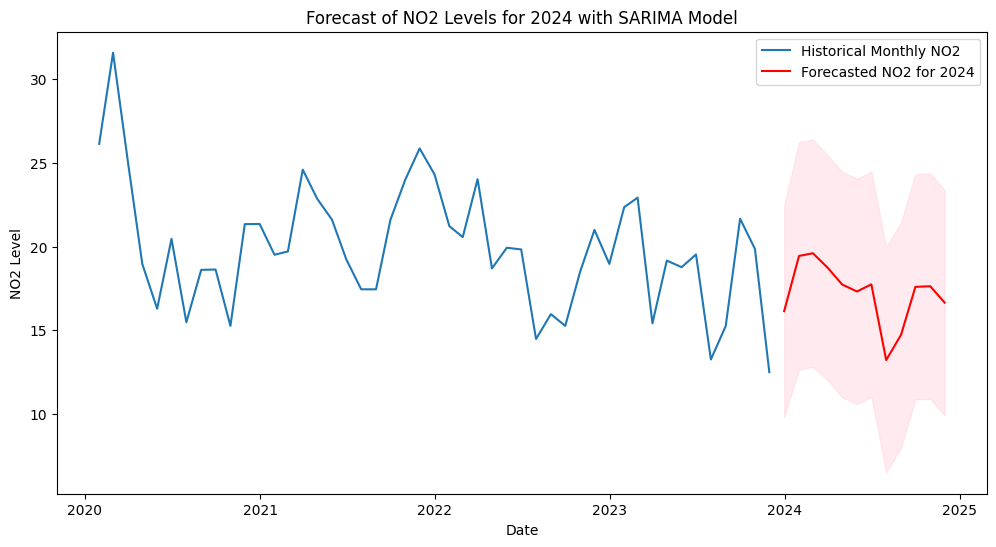

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/Air Quality Forecast/London/Cleaned_London_Air_Quality.csv'
data = pd.read_csv(file_path)

# Convert 'date' to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Filter data from 2020 onwards and resample to monthly frequency
data_2020_onwards = data['no2']['2020-01-01':].resample('M').mean()

# Fit the SARIMA model (with previously determined parameters)
sarima_model = SARIMAX(data_2020_onwards,
                       order=(0, 0, 1),
                       seasonal_order=(1, 0, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

# Forecast for the next 12 months (2024)
forecast = sarima_result.get_forecast(steps=12)
forecast_index = pd.date_range(start=data_2020_onwards.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the historical data and the forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(data_2020_onwards, label='Historical Monthly NO2')
plt.plot(forecast_index, forecast_mean, color='red', label='Forecasted NO2 for 2024')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('Forecast of NO2 Levels for 2024 with SARIMA Model')
plt.xlabel('Date')
plt.ylabel('NO2 Level')
plt.legend()
plt.show()

# Output the forecasted values and confidence intervals
forecast_output = pd.DataFrame({'Forecast': forecast_mean,
                                'Lower CI': forecast_conf_int.iloc[:, 0],
                                'Upper CI': forecast_conf_int.iloc[:, 1]},
                               index=forecast_index)

# Save forecast data to a CSV file
forecast_output.to_csv('/content/drive/MyDrive/Air Quality Forecast/London/NO2_Forecast_2024.csv')

# The path to the saved forecast CSV file
forecast_output_path = '/content/drive/MyDrive/Air Quality Forecast/London/NO2_Forecast_2024.csv'
